# Description

Generates the figure for top cell types for a specified LV (in Settings section below).

# Modules loading

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from data.recount2 import LVAnalysis
from utils import chunker
import conf

# Settings

In [3]:
LV_NAME = "LV5"

In [4]:
LV_AXIS_THRESHOLD = 3.0
N_TOP_SAMPLES = 200
N_TOP_ATTRS = 25

In [5]:
OUTPUT_FIGURES_DIR = Path(
    conf.MANUSCRIPT["FIGURES_DIR"], "lvs_analysis", f"{LV_NAME.lower()}"
).resolve()
display(OUTPUT_FIGURES_DIR)
OUTPUT_FIGURES_DIR.mkdir(parents=True, exist_ok=True)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier_manuscript/content/images/lvs_analysis/lv5')

In [6]:
OUTPUT_CELL_TYPE_FILEPATH = OUTPUT_FIGURES_DIR / f"{LV_NAME.lower()}-cell_types.svg"
display(OUTPUT_CELL_TYPE_FILEPATH)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier_manuscript/content/images/lvs_analysis/lv5/lv5-cell_types.svg')

# Load MultiPLIER summary

In [7]:
multiplier_model_summary = pd.read_pickle(conf.MULTIPLIER["MODEL_SUMMARY_FILE"])

In [8]:
multiplier_model_summary.shape

(2157, 5)

In [9]:
multiplier_model_summary.head()

,pathway,LV index,AUC,p-value,FDR
1,KEGG_LYSINE_DEGRADATION,1,0.388059,0.866078,0.956005
2,REACTOME_MRNA_SPLICING,1,0.733057,0.000048,0.000582
3,MIPS_NOP56P_ASSOCIATED_PRE_RRNA_COMPLEX,1,0.680555,0.001628,0.011366
4,KEGG_DNA_REPLICATION,1,0.549473,0.312155,0.539951
5,PID_MYC_ACTIVPATHWAY,1,0.639303,0.021702,0.083739


# Load data

## Original data

In [10]:
INPUT_SUBSET = "z_score_std"

In [11]:
INPUT_STEM = "projection-smultixcan-efo_partial-mashr-zscores"

In [12]:
input_filepath = Path(
    conf.RESULTS["DATA_TRANSFORMATIONS_DIR"],
    INPUT_SUBSET,
    f"{INPUT_SUBSET}-{INPUT_STEM}.pkl",
).resolve()
display(input_filepath)

assert input_filepath.exists(), "Input file does not exist"

input_filepath_stem = input_filepath.stem
display(input_filepath_stem)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/bases_data/base_orig/results/data_transformations/z_score_std/z_score_std-projection-smultixcan-efo_partial-mashr-zscores.pkl')

'z_score_std-projection-smultixcan-efo_partial-mashr-zscores'

In [13]:
data = pd.read_pickle(input_filepath)

In [14]:
data.shape

(3752, 987)

In [15]:
data.head()

,LV1,LV2,LV3,LV4,LV5,LV6,LV7,LV8,LV9,LV10,...,LV978,LV979,LV980,LV981,LV982,LV983,LV984,LV985,LV986,LV987
100001_raw-Food_weight,-0.695006,1.962565,0.057683,0.878731,-0.539977,1.481272,-0.396422,1.090180,0.759223,0.931395,...,1.129784,1.752343,-1.411403,2.823863,0.931116,-1.054519,0.432982,-0.633597,0.554279,-0.642479
100002_raw-Energy,-1.528127,-0.345309,-0.148953,-0.242060,0.373427,0.791092,0.263477,0.987702,0.354391,1.416059,...,0.224604,0.769882,-0.509482,0.091153,2.286789,-1.008256,-0.029764,1.737229,-0.272107,-0.526125
100003_raw-Protein,-0.704572,-1.011299,0.671420,0.143991,0.615212,0.874212,-0.040998,0.915170,0.254369,-0.084237,...,1.003019,1.044314,-2.376108,0.004778,0.053714,-0.892447,-0.183800,1.377991,-0.278794,-0.419733
100004_raw-Fat,-0.989832,-1.875490,0.261555,-1.420719,0.366238,1.167049,0.257387,0.717674,-0.997664,0.969825,...,0.585913,0.638314,0.119139,-0.140204,1.394326,-1.173402,0.555058,1.013982,-0.544506,-0.064061
100005_raw-Carbohydrate,-0.580143,0.243335,0.158966,-0.036558,0.068176,-0.202639,1.101281,0.675227,1.463432,1.010078,...,-0.249108,-0.026814,0.232713,0.323682,1.168642,-0.282935,0.653105,1.909526,0.199997,-1.656894


## LV data

In [16]:
lv_obj = LVAnalysis(LV_NAME, data)

In [17]:
multiplier_model_summary[
    multiplier_model_summary["LV index"].isin((LV_NAME[2:],))
    & (
        (multiplier_model_summary["FDR"] < 0.05)
        | (multiplier_model_summary["AUC"] >= 0.75)
    )
]

[2021-08-02 22:36:36,396 - numexpr.utils] INFO: NumExpr defaulting to 8 threads.


,pathway,LV index,AUC,p-value,FDR


In [18]:
lv_data = lv_obj.get_experiments_data()

SRP013239, SRP042161, SRP055569, SRP057196, SRP016140, SRP055101, SRP012546, SRP055513, SRP060416, SRP050499, SRP058773, SRP042620, SRP007338, SRP007947, SRP033135, SRP056696, SRP059170, SRP009266, SRP060355, SRP063661, SRP064464, SRP056295, SRP007461, SRP044286, SRP063840, SRP040998, SRP050260, SRP063834, SRP039552, SRP014320, SRP062023, SRP039361, SRP059925, SRP055475, SRP015976, SRP056733, SRP003754, SRP026256, SRP044668, SRP006912, SRP065196, SRP034953, SRP035883, SRP050003, SRP012557, SRP047082, SRP024268, SRP049004, SRP007498, SRP044042, SRP004847, SRP027383, SRP050551, SRP058667, SRP009247, SRP039694, SRP045154, SRP051606, SRP017378, SRP064259, SRP051485, SRP019374, SRP031776, SRP066834, SRP043434, SRP002487, SRP050533, SRP052057, SRP067934, SRP018779, SRP015439, SRP059732, SRP049340, SRP017575, SRP059643, SRP056530, SRP057852, SRP015904, SRP057074, SRP059035, SRP066917, SRP045565, SRP041377, SRP019994, SRP013773, SRP015640, SRP020470, SRP029262, SRP060370, SRP058237, SRP046376,

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (94 != 100)
  warnings.warn(


In [19]:
lv_data.shape

(7641, 138)

In [20]:
lv_data.head()

cell line treatment time cell type patient id subtype  \
project   run                                                               
SRP013239 SRR497904      MCF7            NaN       NaN        NaN     NaN   
          SRR497905      MCF7            NaN       NaN        NaN     NaN   
          SRR497906      MCF7            NaN       NaN        NaN     NaN   
          SRR497907      MCF7            NaN       NaN        NaN     NaN   
          SRR497908      MCF7            NaN       NaN        NaN     NaN   

                    tissue  age c1 chip id experiment_sample_name  \
project   run                                                       
SRP013239 SRR497904    NaN  NaN        NaN                    NaN   
          SRR497905    NaN  NaN        NaN                    NaN   
          SRR497906    NaN  NaN        NaN                    NaN   
          SRR497907    NaN  NaN        NaN                    NaN   
          SRR497908    NaN  NaN        NaN                    NaN   

                    imortalization  ... tgf-beta treatment  \
project   run                       ...                      
SRP013239 SRR497904            NaN  ...                NaN   
          SRR497905            NaN  ...                NaN   
          SRR497906            NaN  ...                NaN   
          SRR497907            NaN  ...                NaN   
          SRR497908            NaN  ...                NaN   

                    tnf-alpha treatment biological replicate human cell line  \
project   run                                                                  
SRP013239 SRR497904                 NaN                  NaN             NaN   
          SRR497905                 NaN                  NaN             NaN   
          SRR497906                 NaN                  NaN             NaN   
          SRR497907                 NaN                  NaN             NaN   
          SRR497908                 NaN                  NaN             NaN   

                    strain organism mapki sensitivity mapki treatment  \
project   run                                                           
SRP013239 SRR497904    NaN      NaN               NaN             NaN   
          SRR497905    NaN      NaN               NaN             NaN   
          SRR497906    NaN      NaN               NaN             NaN   
          SRR497907    NaN      NaN               NaN             NaN   
          SRR497908    NaN      NaN               NaN             NaN   

                    treatment period       LV5  
project   run                                   
SRP013239 SRR497904              NaN  0.007285  
          SRR497905              NaN -0.002271  
          SRR497906              NaN  0.003954  
          SRR497907              NaN -0.000683  
          SRR497908              NaN  0.003359  

[5 rows x 138 columns]

# LV cell types analysis

## Get top attributes

In [21]:
lv_attrs = lv_obj.get_attributes_variation_score()
display(lv_attrs.head(20))

treatment time           0.661326
cell line                0.026736
imortalization           0.019712
culture medium           0.018400
antibody manufacturer    0.007309
age (yrs)                0.006065
cohort                   0.006065
read length              0.005806
library type             0.005806
trimester                0.005169
gestational age          0.005169
tissue origin            0.005161
patient status           0.005161
cell subtype             0.005161
disease state            0.004825
Sex                      0.004428
cell type                0.003651
tumor group              0.003572
antibody vender          0.002826
cell marker              0.002826
dtype: float64

In [22]:
# show those with cell type or tissue in their name
_tmp = pd.Series(lv_attrs.index)
lv_attrs[
    _tmp.str.match(
        "(?:cell.+type$)|(?:tissue$)|(?:tissue.+type$)",
        case=False,
        flags=re.IGNORECASE,
    ).values
].sort_values(ascending=False)

cell subtype      0.005161
cell type         0.003651
tissue subtype    0.001317
tissue            0.001151
tissue type       0.000524
dtype: float64

In [23]:
_tmp = lv_data.loc[
    :,
    [
        "cell type",
        "cell subtype",
        "tissue subtype",
        "tissue",
        "tissue type",
        "cell line",
        LV_NAME,
    ],
]

In [24]:
_tmp_seq = list(chunker(_tmp.sort_values(LV_NAME, ascending=False), 25))

In [25]:
_tmp_seq[0]

cell type  \
project   run                                                             
SRP013239 SRR497919                                                 NaN   
SRP042161 SRR1295278                             Gliomasphere Cell Line   
          SRR1295224                             Gliomasphere Cell Line   
SRP055569 SRR2019010                             U87 human glioma cells   
          SRR2019044                             U87 human glioma cells   
          SRR2019135  mixture of U87 human glioma cells and WI-38 hu...   
          SRR2018995                             U87 human glioma cells   
SRP042161 SRR1294911                                       Glioblastoma   
          SRR1295103                                       Glioblastoma   
SRP057196 SRR1974606                                          microglia   
SRP055569 SRR2019229  mixture of U87 human glioma cells and WI-38 hu...   
SRP016140 SRR592748                           corneal endothelial cells   
SRP055569 SRR1821460  mixture of U87 human glioma cells and MCF10a h...   
SRP055101 SRR1806590                                        endothelial   
          SRR1806592                                        endothelial   
SRP012546 SRR491354                                                 NaN   
SRP042161 SRR1295327                             Gliomasphere Cell Line   
SRP055569 SRR2019049                             U87 human glioma cells   
SRP055513 SRR1818546                                                NaN   
SRP055569 SRR1821430  mixture of U87 human glioma cells and MCF10a h...   
SRP042161 SRR1295316                             Gliomasphere Cell Line   
SRP055513 SRR1818514                                                NaN   
          SRR1818512                                                NaN   
SRP060416 SRR2088253                       tonsil Innate lymphoid cells   
SRP055513 SRR1818569                                                NaN   

                     cell subtype tissue subtype  \
project   run                                      
SRP013239 SRR497919           NaN            NaN   
SRP042161 SRR1295278          NaN            NaN   
          SRR1295224          NaN            NaN   
SRP055569 SRR2019010          NaN            NaN   
          SRR2019044          NaN            NaN   
          SRR2019135          NaN            NaN   
          SRR2018995          NaN            NaN   
SRP042161 SRR1294911          NaN            NaN   
          SRR1295103          NaN            NaN   
SRP057196 SRR1974606          NaN            NaN   
SRP055569 SRR2019229          NaN            NaN   
SRP016140 SRR592748           NaN            NaN   
SRP055569 SRR1821460          NaN            NaN   
SRP055101 SRR1806590          NaN            NaN   
          SRR1806592          NaN            NaN   
SRP012546 SRR491354           NaN            NaN   
SRP042161 SRR1295327          NaN            NaN   
SRP055569 SRR2019049          NaN            NaN   
SRP055513 SRR1818546          NaN            NaN   
SRP055569 SRR1821430          NaN            NaN   
SRP042161 SRR1295316          NaN            NaN   
SRP055513 SRR1818514          NaN            NaN   
          SRR1818512          NaN            NaN   
SRP060416 SRR2088253          NaN            NaN   
SRP055513 SRR1818569          NaN            NaN   

                                               tissue tissue type cell line  \
project   run                                                                 
SRP013239 SRR497919                               NaN         NaN      MCF7   
SRP042161 SRR1295278                              NaN         NaN      CSC8   
          SRR1295224                              NaN         NaN      CSC6   
SRP055569 SRR2019010                              NaN         NaN       NaN   
          SRR2019044                              NaN         NaN       NaN   
          SRR2019135                              NaN         NaN       NaN   

In [26]:
# what is there in these projects?
lv_data.loc[["SRP055101"]].dropna(how="all", axis=1).sort_values(
    LV_NAME, ascending=False
).sort_values(LV_NAME, ascending=False).head(10)

cell type imortalization         culture medium  \
project   run                                                             
SRP055101 SRR1806590  endothelial           none                    F99   
          SRR1806592  endothelial           none                    F99   
          SRR1806591  endothelial           none                    F99   
          SRR1806589  endothelial           none                   none   
          SRR1806588  endothelial           none                   none   
          SRR1806587  endothelial           none                   none   
          SRR1806601  endothelial       SV40 TAg  Human Endothelial-SFM   
          SRR1806599  endothelial       SV40 TAg  Human Endothelial-SFM   
          SRR1806600  endothelial       SV40 TAg  Human Endothelial-SFM   
          SRR1806596  endothelial       SV40 TAg                    F99   

                           LV5  
project   run                   
SRP055101 SRR1806590  0.365068  
          SRR1806592  0.363505  
          SRR1806591  0.295283  
          SRR1806589  0.196251  
          SRR1806588  0.141936  
          SRR1806587  0.123092  
          SRR1806601  0.016556  
          SRR1806599  0.016084  
          SRR1806600  0.015481  
          SRR1806596  0.007253

**MCF7** is a breast cancer cell line.

In [27]:
SELECTED_ATTRIBUTE = "cell type"

In [28]:
# it has to be in the order desired for filling nans in the SELECTED_ATTRIBUTE
SECOND_ATTRIBUTES = ["tissue", "cell line"]

## Get plot data

In [29]:
plot_data = lv_data.loc[:, [SELECTED_ATTRIBUTE] + SECOND_ATTRIBUTES + [LV_NAME]]

In [30]:
# if blank/nan, fill cell type column with tissue content
_new_column = plot_data[[SELECTED_ATTRIBUTE] + SECOND_ATTRIBUTES].fillna(
    method="backfill", axis=1
)[SELECTED_ATTRIBUTE]
plot_data[SELECTED_ATTRIBUTE] = _new_column
plot_data = plot_data.drop(columns=SECOND_ATTRIBUTES)
plot_data = plot_data.fillna({SELECTED_ATTRIBUTE: "NOT CATEGORIZED"})
# plot_data = plot_data.dropna(subset=[SELECTED_ATTRIBUTE])

In [31]:
plot_data = plot_data.sort_values(LV_NAME, ascending=False)

In [32]:
plot_data.head(20)

cell type  \
project   run                                                             
SRP013239 SRR497919                                                MCF7   
SRP042161 SRR1295278                             Gliomasphere Cell Line   
          SRR1295224                             Gliomasphere Cell Line   
SRP055569 SRR2019010                             U87 human glioma cells   
          SRR2019044                             U87 human glioma cells   
          SRR2019135  mixture of U87 human glioma cells and WI-38 hu...   
          SRR2018995                             U87 human glioma cells   
SRP042161 SRR1294911                                       Glioblastoma   
          SRR1295103                                       Glioblastoma   
SRP057196 SRR1974606                                          microglia   
SRP055569 SRR2019229  mixture of U87 human glioma cells and WI-38 hu...   
SRP016140 SRR592748                           corneal endothelial cells   
SRP055569 SRR1821460  mixture of U87 human glioma cells and MCF10a h...   
SRP055101 SRR1806590                                        endothelial   
          SRR1806592                                        endothelial   
SRP012546 SRR491354                     clear cell renal cell carcinoma   
SRP042161 SRR1295327                             Gliomasphere Cell Line   
SRP055569 SRR2019049                             U87 human glioma cells   
SRP055513 SRR1818546                                              liver   
SRP055569 SRR1821430  mixture of U87 human glioma cells and MCF10a h...   

                           LV5  
project   run                   
SRP013239 SRR497919   2.933256  
SRP042161 SRR1295278  2.043265  
          SRR1295224  2.013224  
SRP055569 SRR2019010  0.746010  
          SRR2019044  0.720389  
          SRR2019135  0.636909  
          SRR2018995  0.595701  
SRP042161 SRR1294911  0.490537  
          SRR1295103  0.464022  
SRP057196 SRR1974606  0.461432  
SRP055569 SRR2019229  0.434603  
SRP016140 SRR592748   0.404965  
SRP055569 SRR1821460  0.372847  
SRP055101 SRR1806590  0.365068  
          SRR1806592  0.363505  
SRP012546 SRR491354   0.358973  
SRP042161 SRR1295327  0.339184  
SRP055569 SRR2019049  0.339051  
SRP055513 SRR1818546  0.325443  
SRP055569 SRR1821430  0.322474

## Customize x-axis values

When cell type values are not very clear, customize their names by looking at their specific studies to know exactly what the authors meant.

In [33]:
final_plot_data = plot_data.replace(
    {
        SELECTED_ATTRIBUTE: {
            # General
            "liver": "Liver",
            # SRP013239
            "MCF7": "Breast cancer cell line (MCF7)",
            # SRP055101
            "endothelial": "corneal endothelial cells",
            # SRP055569
            "mixture of U87 human glioma cells and WI-38 human lung fibroblast cells": "Glioma cells + lung fibroblast cells",
            "mixture of U87 human glioma cells and MCF10a human breast cancer cells": "Glioma cells + breast cancer cells",
        }
    }
)

# plot_data = plot_data[plot_data[SELECTED_ATTRIBUTE] != "no cell"]

In [34]:
# add also tissue information to these projects
_srp_code = "SRP057196"
_tmp = final_plot_data.loc[(_srp_code,)].apply(
    lambda x: x[SELECTED_ATTRIBUTE]
    + f" ({lv_data.loc[(_srp_code, x.name), 'tissue']})",
    axis=1,
)
final_plot_data.loc[(_srp_code, _tmp.index), SELECTED_ATTRIBUTE] = _tmp.values

<ipython-input-34-6f1c7e491b69>:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  _tmp = final_plot_data.loc[(_srp_code,)].apply(


In [35]:
# take the top samples only
final_plot_data = final_plot_data.sort_values(LV_NAME, ascending=False)[:N_TOP_SAMPLES]

## Threshold LV values

In [36]:
final_plot_data.loc[
    final_plot_data[LV_NAME] > LV_AXIS_THRESHOLD, LV_NAME
] = LV_AXIS_THRESHOLD

## Delete samples with no tissue/cell type information

In [37]:
final_plot_data = final_plot_data[
    final_plot_data[SELECTED_ATTRIBUTE] != "NOT CATEGORIZED"
]

## Set x-axis order

In [38]:
attr_order = (
    final_plot_data.groupby(SELECTED_ATTRIBUTE)
    .max()
    .sort_values(LV_NAME, ascending=False)
    .index[:N_TOP_ATTRS]
    .tolist()
)

In [39]:
len(attr_order)

25

In [40]:
attr_order[:5]

['Breast cancer cell line (MCF7)',
 'Gliomasphere Cell Line',
 'U87 human glioma cells',
 'Glioma cells + lung fibroblast cells',
 'Glioblastoma']

## Plot

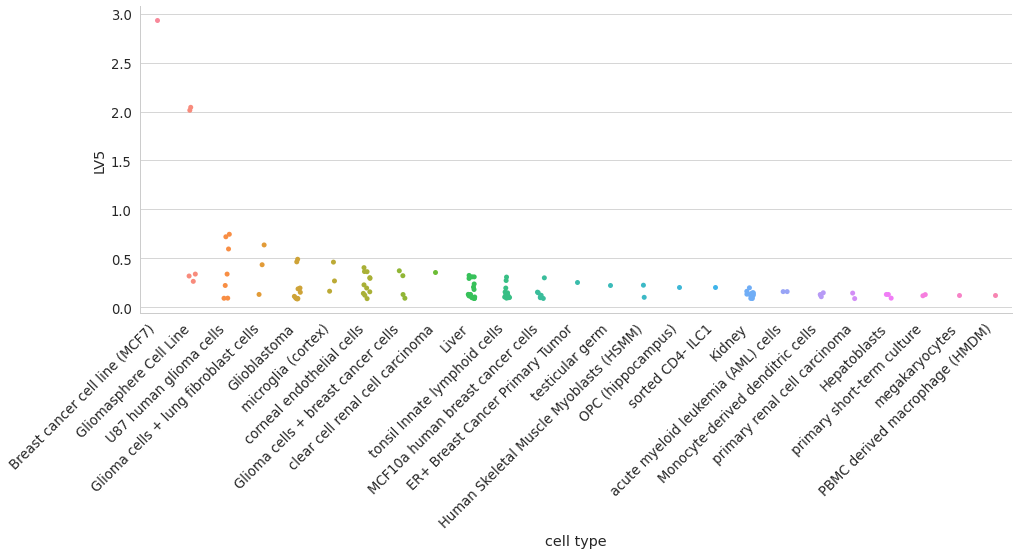

In [41]:
with sns.plotting_context("paper", font_scale=1.5), sns.axes_style("whitegrid"):
    sns.catplot(
        data=final_plot_data,
        y=LV_NAME,
        x=SELECTED_ATTRIBUTE,
        order=attr_order,
        kind="strip",
        height=5,
        aspect=3,
    )
    plt.xticks(rotation=45, horizontalalignment="right")

    plt.savefig(
        OUTPUT_CELL_TYPE_FILEPATH,
        bbox_inches="tight",
        facecolor="white",
    )

# Debug

In [42]:
# with pd.option_context(
#     "display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None
# ):
#     _tmp = final_plot_data[final_plot_data[SELECTED_ATTRIBUTE].str.contains("NOT CAT")]
#     display(_tmp.head(20))

In [43]:
# # what is there in these projects?
# lv_data.loc[["SRP050499"]].dropna(how="all", axis=1).sort_values(
#     LV_NAME, ascending=False
# ).head(60)